In [117]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import pandas_plink as pp

from src import setup
from src.host import run_plink

# This prevents to restart the kernel whenever an external file is edited
%load_ext autoreload
%autoreload 2

# Scripts: see below (computation management)
RUN_SCRIPTS = True
DEFAULT_RECOMPUTE = False
# 
DATA_THINNING = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Introduction

**14'738'460 variants, 622 people.**

## Computation management

<s>
We run all the bash scripts with the function below. Idea: two separate procedures, depending on wether the computations have already been done locally. Principle:

1. Call of the custom function `run(path)` and hide output by default.
    * If `RUN_SCRIPTS` == False, simply do nothing
    * If `RUN_SCRIPTS` == True, run the script
1. `cat` the log file.

Example: while coding or after importing source code, put `RUN_SCRIPTS = True`. While re-running a notebook (ex: check that the code runs), put `RUN_SCRIPTS = False`.
</s>

### Idea

Sometimes we don't want to re-do all the computations if the resulting data is already calculated. Thus we provide:
1. A way of easily running shell commands
1. A dedicated function to easily run plink commands on the shell
1. A way of checking if the results already exist, and loading data if this is the case
    * Unless we specifically specifiy to re-do the calculations.

DOCUMENTATION about running shell commands and managing the outputs : https://janakiev.com/til/python-shell-commands/, https://www.pythonforbeginners.com/os/subprocess-for-system-administrators

### General principle

* `run_shell_command`: manage to run shell commands with a specific package (`subprocess`) that helps to manage the outputs.
* `run_plink`: manage plink version, binary files location, output location, display errors, check if results already exist

**NOTE: possible improvement: automatically find the file extension. Also, if the command results in several output files, we should check that all of them are present (but we assume the user doesn't make such dumb things, i.e. deleting only a fraction of the output files.**

Workflow:
1. Call `run_plink` command with the specific command (e.g. `--freq`), the input, the output and the file extension to look for (to avoid re-doing the computations). 
1. The function checks if the result already exist (needs the output and the extension resulting from the command)
    * already exists: display a message, abort the process (returns 2-tuple of empty strings). This occurs if `force==False` (which is the default value).
1. The command is runned with plink2 by default
1. The error messages are displayed (by default, `verbose_err=True`)
1. The outputs are returned as a tuple (stdout, stderr)

In [118]:
path_raw = setup.PATH_HOST_RAW_PLINK_DATA
path_out = setup.PATH_PLINK_DATA
file_prefix = 'host_geno'

## Overview on raw data

### Files

In [119]:
path = setup.PATH_HOST_RAW_DATA
!ls -lh $path

total 4.0G
-rwxr-xr-x 1 mazeller SV-BA4-unit  245 Aug  9 16:11 dictionary_wes_vcf.txt
-rwxr-xr-x 1 mazeller SV-BA4-unit 2.2G Aug  9 16:11 hbv_gilead.bed
-rwxr-xr-x 1 mazeller SV-BA4-unit 431M Aug  9 16:11 hbv_gilead.bim
-rwxr-xr-x 1 mazeller SV-BA4-unit  18K Aug  9 16:11 hbv_gilead.fam
-rw-r--r-- 1 mazeller SV-BA4-unit 1.4G Aug 11 01:59 hbv_gilead.frq
-rw-r--r-- 1 mazeller SV-BA4-unit  930 Aug 11 01:59 hbv_gilead.log
-rw-r--r-- 1 mazeller SV-BA4-unit  13K Aug 11 01:59 hbv_gilead.nosex
-rw-r--r-- 1 mazeller SV-BA4-unit  677 Aug 11 17:56 hbv_gilead_validate.log


Those are **plink binary files**. 

### Dictionnary of the data

In [120]:
!cat $path/dictionary_wes_vcf.txt

Info about WES_VCF by Ondrej.Podlaha@gilead.com on Dec 12 2018.

1. Human reference genome: GRCh37.87
2. Variant calling was performed using GATK (version nightly-2016-08-27-g667f78b; HaplotypeCaller)
3. dbSNP v138 was used by HaplotypeCaller
 


### Data integrity


In [121]:
o,e= run_plink('--validate', file=path_raw, out=path_out+file_prefix+'_validate', extension='log')
print(o)

run_plink: command '--validate', the file 'data/plink/host_geno_validate.log' already exists (force is set to False).
run_plink was aborted (not an error)


## Arbitrary thinning of the data

We use the plink2 `--thin <p>` option to **reduce the amount of data** (keep entries with probability p). We'll make sure that the code runs first. When everything works, we can simply set `DATA_THINNING = False`.

Management of the **data being taken into account**: we simply put `path_raw` to target the reduced data.

In [122]:
# We change the default raw data for subsequent analyses
if DATA_THINNING == True :
    file_prefix = 'host_reduced'
    run_plink("--thin 0.001 --make-bed", file=path_raw, out=path_out+file_prefix, extension='bed')
    path_raw = path_out+file_prefix

run_plink: command '--thin 0.001 --make-bed', the file 'data/plink/host_reduced.bed' already exists (force is set to False).


In [123]:
!cat $path_out$file_prefix'.log' | grep thin

  --thin 0.001
--thin: 14723971 variants removed (14489 remaining).


<s>
**WARNING: now, the `path_raw` variable targets the reduced data if `DATA_THINNING==True`. Moreover, this path should not be modified in any downstream procedure.**
</s>

# Missing values

`.smiss` for sample-based missing data report:
* MISSING_CT: Number of missing hardcalls, not counting het haploids
* OBS_CT = Denominator (#males on chrY, otherwise #samples)
* F_MISS = Missing hardcall rate, not counting het haploids



In [134]:
path_missing = path_out+file_prefix+'_missing'
o,e = run_plink("--missing", file=path_raw, out=path_missing, extension='vmiss')

run_plink: command '--missing', the file 'data/plink/host_reduced_missing.vmiss' already exists (force is set to False).


In [160]:
df_miss_ind = pd.read_csv(path_missing+'.smiss', sep='\s+', usecols=['F_MISS'])
df_miss_var = pd.read_csv(path_missing+'.vmiss', sep='\s+', usecols=['#CHROM', 'F_MISS'])
print("Shape of missing var table: {}\nColumns of missing var table:\n\t{}\
\nShape of missing ind table: {}\nColumns of missing ind table:\n\t{}"
     .format(df_miss_var.shape, df_miss_var.columns, 
             df_miss_ind.shape, df_miss_ind.columns))

Shape of missing var table: (14489, 2)
Columns of missing var table:
	Index(['#CHROM', 'F_MISS'], dtype='object')
Shape of missing ind table: (622, 1)
Columns of missing ind table:
	Index(['F_MISS'], dtype='object')


## Missingness of individuals per variant

For each individual, plink computed the rate of missing variants. This tells us about how to filter individuals out.

In [161]:
df_miss_ind.head(1)

,F_MISS
0,0.776025


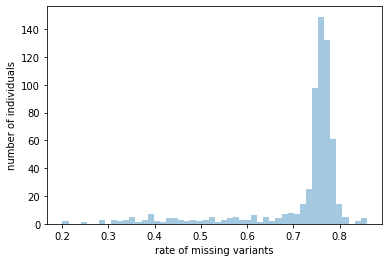

In [162]:
sns.distplot(df_miss_ind['F_MISS'], norm_hist=False, kde=False)
plt.ylabel('number of individuals'); plt.xlabel('rate of missing variants');

## Missing report - variants

For each variant, plink computed the rate of missing individuals. This tells us about how to filter variants out.

In [163]:
df_miss_var.head(1)

,#CHROM,F_MISS
0,1,0.92283


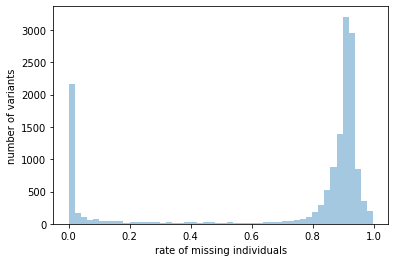

In [164]:
sns.distplot(df_miss_var.F_MISS.dropna(), kde=False, norm_hist=False)
plt.xlabel('rate of missing individuals'); plt.ylabel('number of variants');

### Median missingness per chromosome

**WARNING: this may take a while if the data is not reduced.**

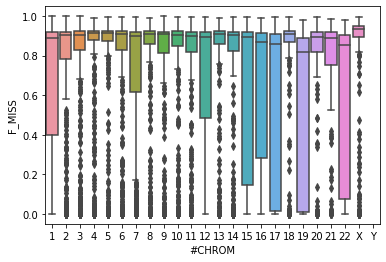

In [165]:
df_miss_chr = df_miss_var[['#CHROM', 'F_MISS']].groupby('#CHROM').median()
sns.boxplot(x='#CHROM', y='F_MISS', data=df_miss_var);

## Summary of missing reports

We indeed expect to have almost no items with very few missing variants: missingness has more to do with the sequencing method and the genome location (than randomness). There is no individual that would be specifically better sequenced than others (excluding randomness). In contrast, we expect some variants to be missing in almost all individuals or to be present in all of them.

Report `.smiss` (individuals): for each individual, we're interested in the rate of missing variants. That tells us which individuals have too much missingness. There is actually a huge number of individuals with a missing rate >80%. It can arise from that fact that:
1. We have low-quality sequencing data
1. If we use reduced data, the sub-sample we have has a lot of missingness by random
1. **Missingness is biased**, since we did not exclude the variants with high missing rates.

Remember that we want to be very careful while excluding individuals, we want to save them due to the small sample size. Just like we did in the viral sequencing data, we must first remove bad variants before removing individuals.


In [132]:
# Free memory
df_miss_var = None
df_miss_ind = None
df_miss_chr = None

# NaN values processing

We use the filtering options of plink2.

**NOTE: after data cleaning, we set `file_prefix = file_prefix+'_clean'`.**

In [94]:
# Define thresholds
THRESHOLD_INDIVIDUALS = 0.1
THRESHOLD_VARIANTS = 0.05

In [79]:
# Managing paths and files
file_prefix = file_prefix + '_clean'
path_clean = path_out+file_prefix

In [95]:
path_clean_intermed = path_clean+'_intermed'
o,e = run_plink('--geno ' + str(THRESHOLD_VARIANTS) + ' --make-bed',
                 file=path_raw, out=path_clean_intermed, extension='bed', force=True)
print(o)

PLINK v2.00a2LM 64-bit Intel (31 Jul 2019)     www.cog-genomics.org/plink/2.0/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to data/plink/host_reduced_clean_intermed.log.
Options in effect:
  --bfile data/plink/host_reduced
  --geno 0.05
  --make-bed
  --out data/plink/host_reduced_clean_intermed

Start time: Sun Aug 11 19:51:52 2019
64232 MiB RAM detected; reserving 32116 MiB for main workspace.
Using up to 16 threads (change this with --threads).
622 samples (0 females, 0 males, 622 ambiguous; 622 founders) loaded from
data/plink/host_reduced.fam.
14489 variants loaded from data/plink/host_reduced.bim.
Note: No phenotype data present.
Calculating allele frequencies... 0%done.
--geno: 12068 variants removed due to missing genotype data.
2421 variants remaining after main filters.
Writing data/plink/host_reduced_clean_intermed.fam ... done.
Writing data/plink/host_reduced_clean_intermed.bim ... done.
Writing data/plink/host_reduced_clean_inte

In [96]:
o,e = run_plink('--mind ' + str(THRESHOLD_INDIVIDUALS) + ' --make-bed',
                file=path_clean_intermed, out=path_clean, extension='bed', force=True)
print(o)

PLINK v2.00a2LM 64-bit Intel (31 Jul 2019)     www.cog-genomics.org/plink/2.0/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to data/plink/host_reduced_clean.log.
Options in effect:
  --bfile data/plink/host_reduced_clean_intermed
  --make-bed
  --mind 0.1
  --out data/plink/host_reduced_clean

Start time: Sun Aug 11 19:52:58 2019
64232 MiB RAM detected; reserving 32116 MiB for main workspace.
Using up to 16 threads (change this with --threads).
622 samples (0 females, 0 males, 622 ambiguous; 622 founders) loaded from
data/plink/host_reduced_clean_intermed.fam.
2421 variants loaded from data/plink/host_reduced_clean_intermed.bim.
Note: No phenotype data present.
Calculating sample missingness rates... 0%done.
10 samples removed due to missing genotype data (--mind).
IDs written to data/plink/host_reduced_clean.mindrem.id .
612 samples (0 females, 0 males, 612 ambiguous; 612 founders) remaining after
main filters.
Writing data/plink/host_reduce

## Check again missingness


run_plink: command '--missing', the file 'data/plink/host_reduced_clean.vmiss' already exists (force is set to False).


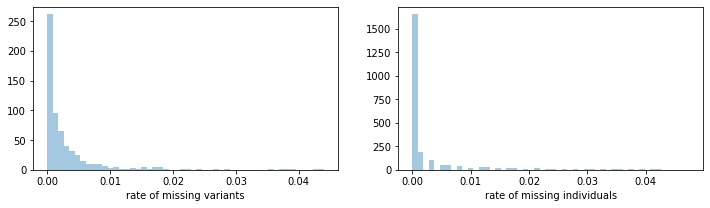

In [159]:
# Run plink
run_plink('--missing', file=path_clean, out=path_clean, extension='vmiss')
# Put in DataFrames
# NOTE: param usecols DRASTICALLY lowers the amount of memory used
df_miss_ind = pd.read_csv(path_clean+'.smiss', sep='\s+', usecols=['F_MISS'])
df_miss_var = pd.read_csv(path_clean+'.vmiss', sep='\s+', usecols=['F_MISS'])
# Plotting
fig, ax = plt.subplots(1,2, figsize=(12, 3))
sns.distplot(df_miss_ind.F_MISS.dropna(), kde=False, ax=ax[0])
ax[0].set_xlabel('rate of missing variants')
sns.distplot(df_miss_var.F_MISS.dropna(), kde=False, ax=ax[1])
ax[1].set_xlabel('rate of missing individuals');
# Free memory
df_miss_var = None
df_miss_ind = None

# Minor allele frequencies

## plink1.9 report

* A1: minor allele (usually)
* A2: major allele (usually)
* MAF: frequency of A1

run_plink: command '--freq', the file 'data/plink/host_reduced_clean.frq' already exists (force is set to False).


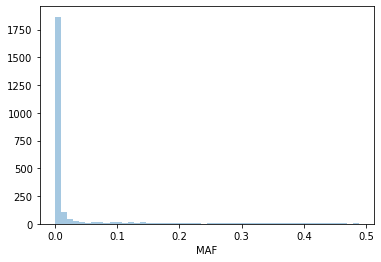

In [168]:
path_freq = path_clean
run_plink('--freq', extension='frq', file=path_clean, out=path_freq, plink2=False);
df_freq = pd.read_csv(path_freq+".frq", sep="\s+")
df_freq.head(1)
sns.distplot(df_freq.MAF.dropna(), kde=False);

In [169]:
frequencies = [0.1, 0.05, 0.01, 0.005]
print("Percentage of variants to drop for different frequency thresholds:")
N = len(df_freq.MAF)
for f in frequencies :
    variants = df_freq.MAF[df_freq.MAF < f]
    print("{}\t{:.3}%".format(f, len(variants)/N*100))

Percentage of variants to drop for different frequency thresholds:
0.1	87.9%
0.05	85.1%
0.01	77.4%
0.005	72.8%


## plink2 report

run_plink: command '--freq', the file 'data/plink/host_reduced_clean.afreq' already exists (force is set to False).


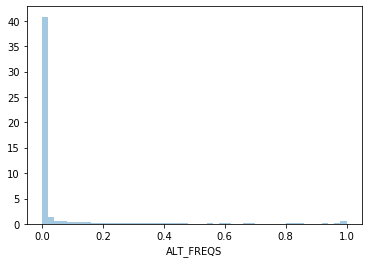

In [170]:
path_freq = path_clean
run_plink('--freq', extension='afreq', file=path_clean, out=path_freq);
df_freq = pd.read_csv(path_freq+".afreq", sep="\s+")
df_freq.head(1)
sns.distplot(df_freq.ALT_FREQS.dropna(), kde=False, norm_hist=True);

## MAF summary



In [171]:
df_freq = None

# Hardy-Weinberg equilibrium

* A1: Tested allele
* AX: Non-A1 alleles (comma-separated)
* HOM_A1_CT: Homozygous-A1 genotype count
* HET_A1_CT: Heterozygous-A1 genotype count
* TWO_AX_CT: number of NONmissing calls with no A1 copies
* O(HET_A1): Observed heterozygous-major frequency
* E(HET_A1): Expected heterozygous-major frequency
* P: Hardy-Weinberg equilibrium exact test p-value

In [172]:
path_hardy = path_raw+'_hardy'
run_plink('--hardy', file=path_raw, out=path_hardy, extension='hardy');

run_plink: command '--hardy', the file 'data/plink/host_reduced_hardy.hardy' already exists (force is set to False).


In [173]:
df_hardy = pd.read_csv(path_hardy+'.hardy', sep="\s+")
df_hardy.head(10)

,#CHROM,ID,A1,AX,HOM_A1_CT,HET_A1_CT,TWO_AX_CT,O(HET_A1),E(HET_A1),P
0,1,rs12238997,A,G,42,4,2,0.083333,0.152778,2.272870e-02
1,1,1:726605:C:CGAATG,C,CGAATG,72,1,0,0.013699,0.013605,1.000000e+00
2,1,1:726819:G:GATCTA,GATCTA,G,145,0,1,0.000000,0.013605,3.436430e-03
3,1,rs778519663,CTAGACACACACACCTGGACACACACACG,C,35,0,6,0.000000,0.249851,5.427240e-08
4,1,rs148661787,G,A,605,1,0,0.001650,0.001649,1.000000e+00
5,1,rs17160781,T,C,586,5,3,0.008418,0.018347,4.138240e-06
6,1,1:1277676:C:T,C,T,613,1,0,0.001629,0.001627,1.000000e+00
7,1,1:1405421:C:T,C,T,107,1,0,0.009259,0.009216,1.000000e+00
8,1,rs577360633,G,GC,621,1,0,0.001608,0.001606,1.000000e+00
9,1,rs75174864,T,G,56,4,10,0.057143,0.284082,4.863510e-09


***
***
<br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br />